In [226]:
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns

from astropy import units as u
from astropy import constants as c

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [228]:
sns.set_style('darkgrid')

## Constants

In [16]:
# cgs units
solMass   = (1 * u.solMass).cgs.value
solRad    = (1 * u.solRad).cgs.value
jupMass   = (2 * u.jupiterMass).cgs.value
earthMass = (1 * u.earthMass).cgs.value
G         = (1 * c.G).cgs.value
AU        = (1 * u.au).cgs.value
year      = (1 * u.year).cgs.value
day       = (1 * u.day).cgs.value
earth_v   = (30 * u.km/u.s).value
moon_v    = (1 * u.km/u.s).cgs.value

## Velocity and acceleration

Calculates velocity and acceleration on $m_i$ due to $m_j$ and $m_k$

In [17]:
def sho_func(t, uin_i, m_j, uin_j, m_k, uin_k):
    # position and velocity
    r_i = uin_i[:2]
    v_i = uin_i[2:]
    
    r_j = uin_j[:2]
    r_k = uin_k[:2] 
    # position vector pointing from one of the two masses to m_i
    d_ij = np.linalg.norm(r_j - r_i)
    d_ik = np.linalg.norm(r_k - r_i)

    # calulating accelerations
    g = (G*m_j/d_ij**3) * (r_j - r_i) + (G*m_k/d_ik**3) * (r_k - r_i)
    
    derivs = np.ndarray(4)
    derivs[:2] = v_i
    derivs[2:] = g
    
    return derivs

## Integrator

Iterates the solution

In [18]:
def sho_RK4(t, uold_i, m_j, uold_j, m_k, uold_k, dt):
    K1 = sho_func(t, uold_i, m_j, uold_j, m_k, uold_k)
    K2 = sho_func(t + dt/2, uold_i + K1*dt/2, m_j, uold_j, m_k, uold_k)
    K3 = sho_func(t + dt/2, uold_i + K2*dt/2, m_j, uold_j, m_k, uold_k)
    K4 = sho_func(t + dt, uold_i + K3*dt, m_j, uold_j, m_k, uold_k)
    
    unew_i = uold_i + (dt/6)*(K1 + 2*(K2 + K3) + K4)
    return unew_i

# Simulation

integrate orbit and return positions and velocities, all in cgs

Inputs:
* $q \equiv m_3 / m_2$
* host_mass: mass of host star, located at origin
* secondary_mass: mass of hot jupiter
* scndry_x: x position of secondary, relative to origin (host star)
* scndry_vx: x component of secondary's velocity (default 0 for Keplerian orbit)
* cmpn_x: x positon of companion to secondary in units of secondary x
* cmpn_y: y position of companions relative to secondary (not in units of)
* cmpn_vx: x component of companion velocity
* cmpn_vy: y component of companion velocity in units of secondary's velocity in the y
* t_frac: raction of the orbital period of secondary, in absence on the companion, that the simulation will run up to
* f: fudge factor for adaptive timestep procedure, where $dt = 10^f\ r_0 / v_0$,
with $r_0$ being the distance of the companion from the secondary at the beginning of the timestep and $v_0$ being its absolute speed at the beginning of the timestep

Outputs:
* mi_coords: a (number of timesteps) $\times$ (4) array, where the 4 columns are x_i, y_i, vx_i, and vy_i, respectively for the ith object. In this run,
* i = 1: primary
* i = 2: secondary
* i = 3: companion

In [272]:
def run_orb(q, host_mass, scndry_mass, scndry_x, scndry_y, scndry_vx, scndry_vy,\
cmpn_x, cmpn_y, cmpn_vx, cmpn_vy, t_frac, dt):
    m_1 = host_mass # host star
    m_2 = scndry_mass #m_1 / 5000 # hot jupiter
    m_3 = q * m_2  # companion

    # m1: primary (hardcoded)
    x_1  =  0.0
    y_1  =  0.0
    vx_1 =  0.0
    vy_1 =  0.0

    # m2: secondary
    x_2  = scndry_x
    y_2  = scndry_y # doesn't matter where it starts on y because of symmetry of system
    vx_2 = scndry_vx
    vy_2 = scndry_vy # assuming Keplerian for now

    # m3: companion 
    x_3  = cmpn_x
    y_3  = cmpn_y 
    vx_3 = cmpn_vx
    vy_3 = cmpn_vy 
    
    # characteristic timescale set by secondary's orbital timescale
    T0 = 2*np.pi*np.sqrt(np.abs(x_2)**3/(G*m_1))
    tmax  = t_frac * T0

    uold_1 = np.array( [x_1, y_1, vx_1, vy_1] )
    uold_2 = np.array( [x_2, y_2, vx_2, vy_2] )
    uold_3 = np.array( [x_3, y_3, vx_3, vy_3] )

    m1_coord = uold_1
    m2_coord = uold_2
    m3_coord = uold_3
    
    t = 0
    t_list = [t]
    while (t <= tmax):
        # r0, v0 based on speed at beginning of current timestep
        r0 = np.sqrt( (uold_3[0] - uold_2[0])**2 + (uold_3[1] - uold_2[1])**2 )
        v0 = np.sqrt(uold_3[2]**2 + uold_3[3]**2) 
        dt = 10**(f) * r0 / v0

        unew_1 = sho_RK4(t, uold_1, m_2, uold_2, m_3, uold_3, dt) # sun
        unew_2 = sho_RK4(t, uold_2, m_1, uold_1, m_3, uold_3, dt) # earth
        unew_3 = sho_RK4(t, uold_3, m_1, uold_1, m_2, uold_2, dt) # moon

        m1_coord = np.vstack( (m1_coord, unew_1) )
        m2_coord = np.vstack( (m2_coord, unew_2) )
        m3_coord = np.vstack( (m3_coord, unew_3) )

        # step forward
        uold_1 = unew_1 
        uold_2 = unew_2
        uold_3 = unew_3
        t += dt
        t_list.append(t)
            
    return m1_coord, m2_coord, m3_coord, np.array(t_list)

# Get results from `run_orb`

In [273]:
# mass ratio
q              = 0.001
# primary
host_mass      = solMass
# secondary
scndry_mass    = 20*jupMass
scndry_x       = -0.01*AU
scndry_y       = 0.0
scndry_vx      = 0.0
scndry_vy      = -np.sqrt(G*m_1/np.abs(scndry_x)) # assuming Keplerian for now
# companion
cmpn_x         = 1.1*scndry_x  
cmpn_y         = scndry_y
cmpn_vx        = 0.0 
cmpn_vy        = 0.5*scndry_vy 

# time options
t_frac         = 1.5
f              = -2 # add to run_orb for adaptive timestep

# r0, v0 based on speed at beginning of first timestep
# use prescription inside while loop below for adaptive time-stepping
#r0 = np.sqrt( (cmpn_x - scndry_x)**2 + (cmpn_y - scndry_y)**2 )
#v0 = np.sqrt(cmpn_vx**2 + cmpn_vy**2) 
#dt = 10**(f) * r0 / v0

# run simulation
m1_coord, m2_coord, m3_coord, time = run_orb(q, host_mass, scndry_mass, scndry_x, scndry_y,\
scndry_vx, scndry_vy, cmpn_x, cmpn_y, cmpn_vx, cmpn_vy, t_frac, dt)

## Center of Mass

Calculates the position and velocity of the center or mass relative to the origin. This is needed for calculating things like the total angular momentum of the system when the origin
is arbitrarily placed.

In [274]:
def get_COM_pos(m1, r1, m2, r2, m3, r3): # return COM position vector relative to origin    
    M = m1 + m2 + m3
    x_COM = (m1*r1[0] + m2*r2[0] + m3*r3[0]) / M
    y_COM = (m1*r1[1] + m2*r2[1] + m3*r3[1]) / M
    
    return x_COM, y_COM

# COM_t: center of mass relative to origin at time t
m_1 = host_mass # host star
m_2 = scndry_mass #m_1 / 5000 # hot jupiter
m_3 = q * m_2  # companion
COM_pos = []
for t in range(len(m1_coord)):
    COM_pos_t = get_COM_pos(m_1, m1_coord[t][:2], m_2, m2_coord[t][:2], m_3, m3_coord[t][:2])
    COM_pos.append(COM_pos_t)

COM_pos = np.array(COM_pos)

# Use this to calculate the velocity by approximating zero acceleratino 
# between timesteps.
def get_COM_vel(x_COM_0, x_COM_f, y_COM_0, y_COM_f, dt):
    vx_COM = (x_COM_f - x_COM_0) / dt
    vy_COM = (y_COM_f - y_COM_0) / dt
    
    return vx_COM, vy_COM

COM_vel = []
for t in range(len(COM_pos) - 1):
    COM_vel_t = get_COM_vel(COM_pos[t][0], COM_pos[t+1][1], \
                            COM_pos[t][0], COM_pos[t+1][1], dt)
    COM_vel.append(COM_vel_t)
COM_vel = np.array(COM_vel)

## Angular Momentum

This uses the center of mass information in the previous section to calculate the system angular momentum in the reference frame of the origin (where the host star starts). In this system,
$$
\vec{L} = \sum_i \left( \vec R_i \times m_i\vec V_i \right) =
R \times M \vec V + \sum_i\vec r_i\times m_i\vec v_i \quad .
$$

where,

$m_i$: mass of particle $i$ 

$\vec R_i$: position of particle $i$ vs. origin

$\vec V_i$: velocity of particle $i$ vs. origin

$\vec R$: position of center or mass vs. origin

$\vec V$: velocity of center or mass vs. origin

$\vec r_i$: position of particle $i$ vs. center of mass

$\vec v_i$: velocity of particle $i$ vs. center of mass

In [275]:
# takes cross product, assuming z-component of position and velocity are zero.
# resulting vector will be in z-hat direction
def cross_2D(u, v):
    ux, uy = u[0], u[1]
    vx, vy = v[0], v[1]
    
    return (ux*vy - uy*vx)

In [276]:
# calcualtes total angular momentum at time t
def get_L(R, m, V):
    l_1 = m[0]*cross_2D(R[0], V[0])
    l_2 = m[1]*cross_2D(R[1], V[1])
    l_3 = m[2]*cross_2D(R[2], V[2])
    
    return l_1 + l_2 + l_3

In [277]:
L_list = []
for t in range(len(m1_coord)):
    R_list = [m1_coord[t,:][:2], m2_coord[t,:][:2], m3_coord[t,:][:2]] 
    m_list = [m_1, m_2, m_3]
    V_list = [m1_coord[t,:][2:], m2_coord[t,:][2:], m3_coord[t,:][2:]] 
    L = get_L(R_list, m_list, V_list)
    L_list.append(L)

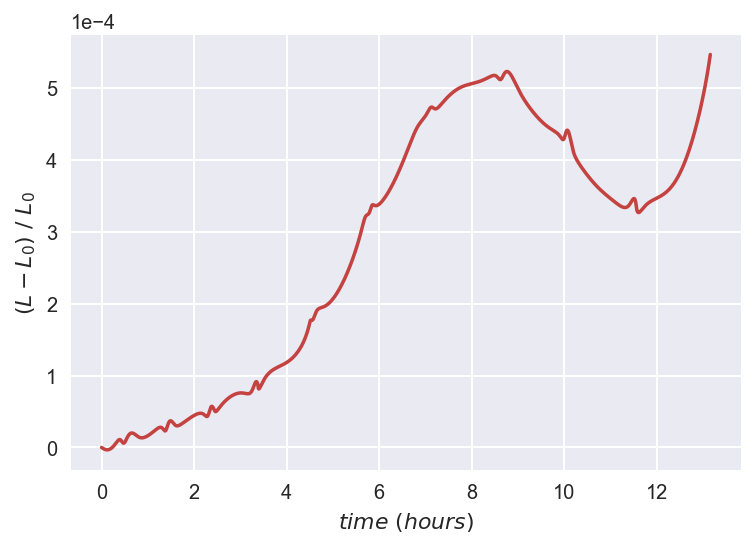

In [278]:
fig, ax = plt.subplots(1, 1)

t = (time * u.s).to('hr')
ax.plot(t, (L_list - L_list[0]) / L_list[0])
ax.set_xlabel(r'$time\ (hours)$')
ax.set_ylabel(r'$(L - L_0)\ /\ L_0$')

ax.yaxis.get_major_formatter().set_powerlimits((0, 1))

## Total Energy

Calculates potential energy of $m_i$ in presence of $m_j$ and $m_k$ and kinetic energy of each particle.

In [279]:
def get_U(m_i, r_i, m_j, r_j, m_k, r_k):
    r_ij = np.linalg.norm(r_j - r_i)
    r_ik = np.linalg.norm(r_k - r_i)

    if (r_ij != 0.0 and r_ik != 0.0):
        U_ij = -G * m_i*m_j / r_ij 
        U_ik = -G * m_i*m_k / r_ik
    else:
        U_ij, U_ik = 0.0, 0.0 # will use later for collision detection
    
    return U_ij + U_ik

total_U = []
for t in range(len(time)):
    U_1 = get_U(m_1, m1_coord[t][:2], m_2, m2_coord[t][:2], m_3, m3_coord[t][:2])
    U_2 = get_U(m_2, m2_coord[t][:2], m_1, m1_coord[t][:2], m_2, m2_coord[t][:2])
    U_3 = get_U(m_3, m3_coord[t][:2], m_1, m1_coord[t][:2], m_2, m2_coord[t][:2])
    
    U_tot = U_1 + U_2 + U_3
    total_U.append(U_tot)
total_U = np.array(total_U)

def get_K(t):
    v_1 = np.linalg.norm(m1_coord[t][2:])
    v_2 = np.linalg.norm(m2_coord[t][2:])
    v_3 = np.linalg.norm(m3_coord[t][2:])

    K_t = 0.5 * (m_1*v_1**2 + m_2*v_2**2 + m_3*v_3**2)
    
    return K_t

total_K = []
for t in range(len(time)):
    K_t = get_K(t)
    total_K.append(K_t)
total_K = np.array(total_K)

total_E = total_K + total_U

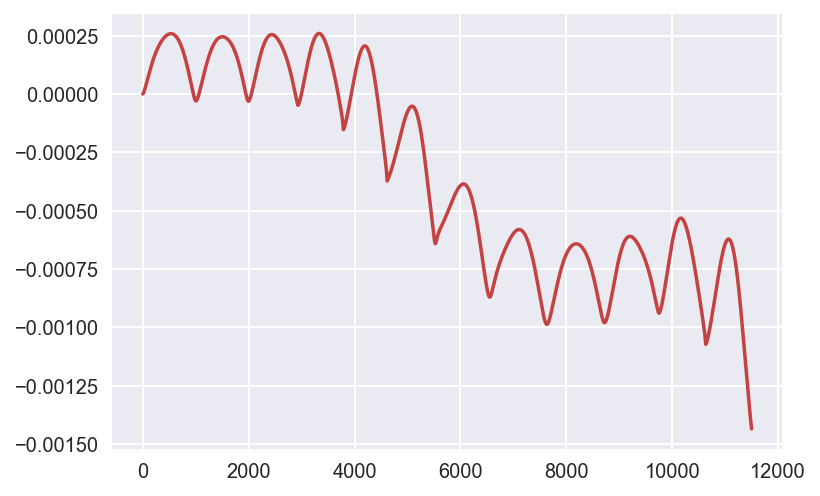

In [280]:
plt.plot((total_E - total_E[0])/total_E[0])

## Plot Trajectories

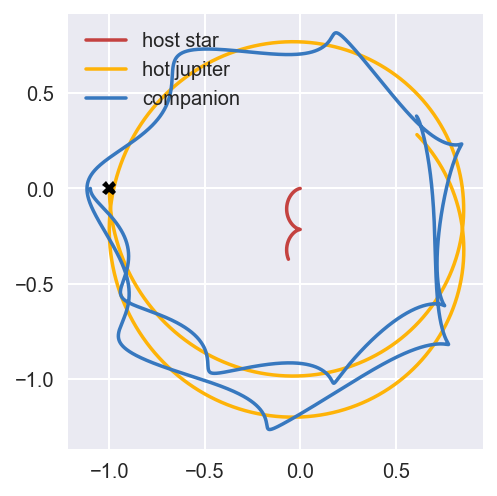

In [281]:
fig, ax = plt.subplots(1,1)

colors = ["reddish", "amber", "windows blue"]#, "faded green", "dusty purple"]
sns.set_palette(sns.xkcd_palette(colors))

ax.set_aspect("equal")

L = np.abs(m2_coord[0][0])

x_1 = m1_coord[:,0] / L
y_1 = m1_coord[:,1] / L
x_2 = m2_coord[:,0] / L
y_2 = m2_coord[:,1] / L
x_3 = m3_coord[:,0] / L
y_3 = m3_coord[:,1] / L

ax.plot(x_1, y_1, label='host star')
ax.plot(x_2, y_2, label='hot jupiter')
ax.plot(x_3, y_3, label='companion')
ax.plot(x_2[0], y_2[0], 'kX')
#ax.plot(COM_coord[:,0] / L, COM_coord[:,1] / L, 'g.')

margin = 0.1
lim_x_neg = np.min(np.concatenate((x_1,x_2,x_3))) - margin
lim_x_pos = np.max(np.concatenate((x_1,x_2,x_3))) + margin
lim_y_neg = np.min(np.concatenate((y_1,y_2,y_3))) - margin
lim_y_pos = np.max(np.concatenate((y_1,y_2,y_3))) + margin

ax.set_xlim(lim_x_neg, lim_x_pos)
ax.set_ylim(lim_y_neg, lim_y_pos)
ax.legend(loc='best')

plt.show()

# Animation Preview

In [284]:
from matplotlib import animation, rc
from IPython.display import HTML

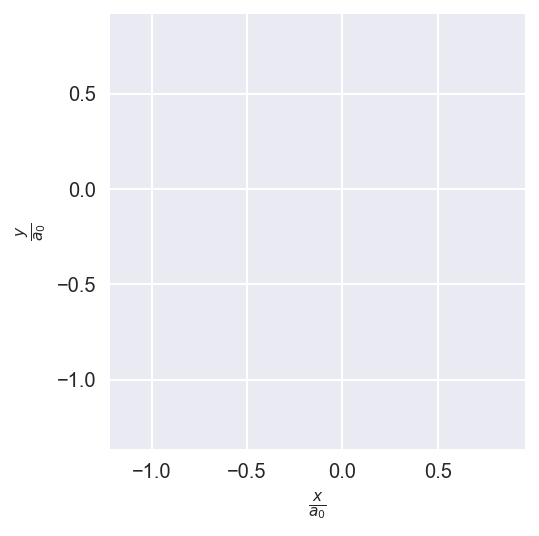

In [285]:
fig, ax = plt.subplots(figsize = (4,4))
ax.set_xlabel(r"$\frac{x}{a_0}$")
ax.set_ylabel(r"$\frac{y}{a_0}$")

#fig.subplots_adjust(left=0, bottom=0, right=1, top=1, 
#                    wspace=None, hspace=None)
nstep = int(len(x_2) / 300) # sample every n steps
x_1_downsamp = x_1[::nstep]
y_1_downsamp = y_1[::nstep]
x_2_downsamp = x_2[::nstep]
y_2_downsamp = y_2[::nstep]
x_3_downsamp = x_3[::nstep]
y_3_downsamp = y_3[::nstep]

# primary
#line0, = ax.plot([], [], lw=2) # marker
patch = plt.Circle((0, 0), solRad / L, fc=sns.xkcd_palette(["pinkish orange"])[0])
# secondary
line1, = ax.plot([], [], lw=2) # trail
line2, = ax.plot([], [], lw=2) # marker
# companion
line3, = ax.plot([], [], lw=2) # trail
line4, = ax.plot([], [], lw=2) # marker
# primary center
line5, = ax.plot([], [], lw=2) # trail
line6, = ax.plot([], [], lw=2) # marker

line = [patch, line1, line2, line3, line4, line5, line6]

ax.set_xlim(lim_x_neg, lim_x_pos)
ax.set_ylim(lim_y_neg, lim_y_pos)
ax.set_aspect("equal")

# initialization function: plot the background of each frame
def init():
    # primary
    ax.add_patch(patch)
    #line[0].set_data([], [])
    # secondary
    line[1].set_data([], [])
    line[2].set_data([], [])
    # companion
    line[3].set_data([], [])
    line[4].set_data([], []) 
    # primary center
    line[5].set_data([], [])
    line[6].set_data([], [])
    
    return line

# animation function. This is called sequentially
def animate(i):
    # primary
    patch.center = (x_1_downsamp[i], y_1_downsamp[i])
    # plot the trajectory
    line[5].set_data(x_1_downsamp[:i+1], y_1_downsamp[:i+1]) 
    line[5].set_color('w') # i+1 makes it inclusive
    # add a point at the end
    line[6].set_data(x_1_downsamp[i], y_1_downsamp[i])
    line[6].set_marker('X')
    line[6].set_markersize(10)
    line[6].set_markeredgecolor('w')
    line[6].set_markeredgewidth(2)
    line[6].set_color('w')
    # secondary
    line[1].set_data(x_2_downsamp[:i+1], y_2_downsamp[:i+1]) # i+1 makes it inclusive
    line[1].set_color(sns.xkcd_palette(["amber"])[0])  
    # add a point at the end
    line[2].set_data(x_2_downsamp[i], y_2_downsamp[i])
    line[2].set_marker('o')
    line[2].set_markersize(10)
    line[2].set_markeredgecolor('k')
    line[2].set_markeredgewidth(2)
    line[2].set_color(sns.xkcd_palette(["amber"])[0])
        
    # companion
    # plot the trajectory
    line[3].set_data(x_3_downsamp[:i+1], y_3_downsamp[:i+1]) 
    line[3].set_color(sns.xkcd_palette(["windows blue"])[0]) # i+1 makes it inclusive
    # add a point at the end
    line[4].set_data(x_3_downsamp[i], y_3_downsamp[i])
    line[4].set_marker('o')
    line[4].set_markersize(10)
    line[4].set_markeredgecolor('k')
    line[4].set_markeredgewidth(2)
    line[4].set_color(sns.xkcd_palette(["windows blue"])[0])
    
    return line

In [286]:
# call the animator. blit=True re-draws just the parts that have 
# changed to make things a bit faster

# remove white margin
#fig.subplots_adjust(left=0, bottom=0, right=1, top=1, 
#                    wspace=None, hspace=None)
N = len(x_2_downsamp)
spf = 0.05 # seconds per frame
anim = animation.FuncAnimation(fig, animate, frames=N, init_func=init, 
                               interval = (spf * 1000), blit=True)
HTML(anim.to_html5_video())

# High Quality Movie

Save high quality mp4 of preview above

In [287]:
# call the animator. blit=True re-draws just the parts that have 
# changed to make things a bit faster

# remove white margin
#fig.subplots_adjust(left=0, bottom=0, right=1, top=1, 
#                    wspace=None, hspace=None)
N = len(x_2_downsamp)
spf = 0.05 # seconds per frame

FFMpegWriter = animation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')

# Change the video bitrate as you like and add some metadata.
mywriter = FFMpegWriter(fps=15, metadata=metadata)

anim = animation.FuncAnimation(fig, animate, frames=N, init_func=init, 
                               interval = (spf * 1000), blit=True)

anim.save("./orb.mp4", writer=mywriter, dpi=500, codec=None)
anim.save("./orb.gif", writer="imagemagick", dpi=50, codec=None)